# SST correlation and regression maps

## Regressed on a time series, filtered to different frequencies

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# NOAA PSD https://psl.noaa.gov/data/gridded/index.html

URL = 'https://psl.noaa.gov//thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
ds = xr.open_dataset(URL)
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2019, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-04-06
    DODS_EXTRA.Unlimited_Dimension:  time

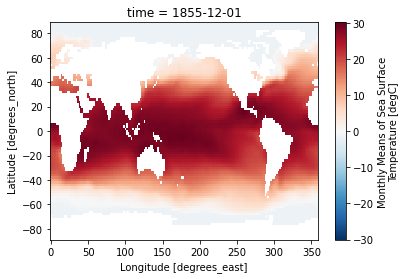

In [96]:
ds.sst[23].plot()

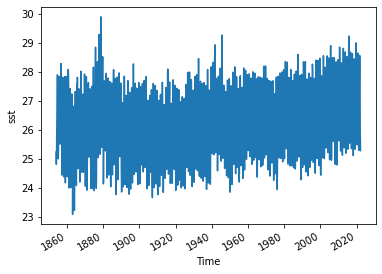

In [75]:
# Pick a point or box 
#BOX = ds.sst.sel(lat=20,lon=300).drop_vars(['lat','lon'])

# Caribbean roughly 
BOX = ds.sst.sel( lat=slice(25,15),lon=slice(300,310) ).mean(dim=['lat','lon'])

BOX.plot()

In [5]:
BOX = ds.sst.sel( lat=slice(25,15),lon=slice(300,310) ).mean(dim=['lat','lon'])


# regress on time to get trend

In [24]:
BOX

<xarray.DataArray 'sst' (time: 2019)>
array([25.237095, 24.813852, 24.925028, ..., 25.90333 , 25.532452,
       25.284887], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-03-01

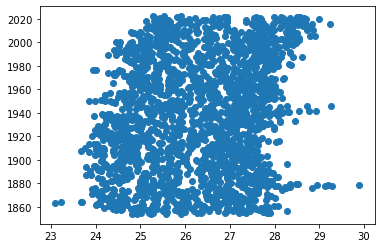

In [26]:
plt.scatter(BOX.values, BOX.time.values)

In [27]:
# correlation with time is the trend: upward (positive) 0.16435173719492452
timecor = np.corrcoef(BOX.values, range(BOX.size))[1,0]; timecor

0.18729148132531573

582.8350252572907

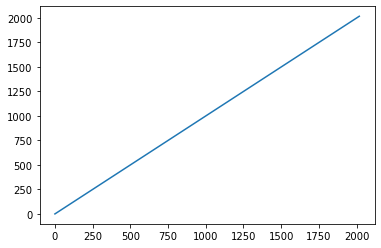

In [28]:
# stdev of a linear trend: units are months 
plt.plot(range(BOX.size))
np.std( range(BOX.size) )

In [29]:
# stdev of SST 
np.std( BOX ).values

array(1.246512, dtype=float32)

In [30]:
# Slope is K/month units 
slope = timecor *np.std(BOX).values /np.std( range(BOX.size) ); slope

# Trend is a time series of the right shape, equal to the mean plos the trend
trend = BOX.copy()*0 +BOX.mean() + slope*range(BOX.size)

Text(0.5, 1.0, '0N, 180E SST and trend')

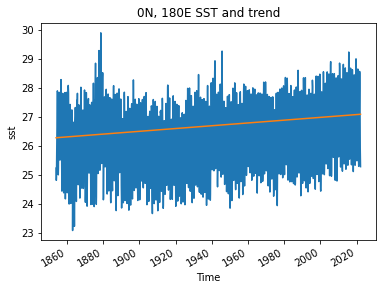

In [31]:
BOX.plot(); trend.plot(); plt.title('0N, 180E SST and trend')

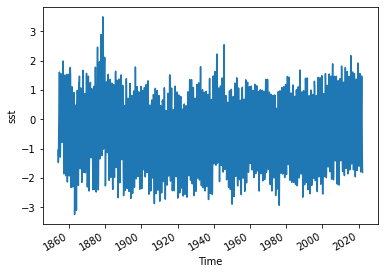

In [32]:
detrend = BOX-trend
detrend.plot()

# Regress on month of year (mm) to get seasonal cycle

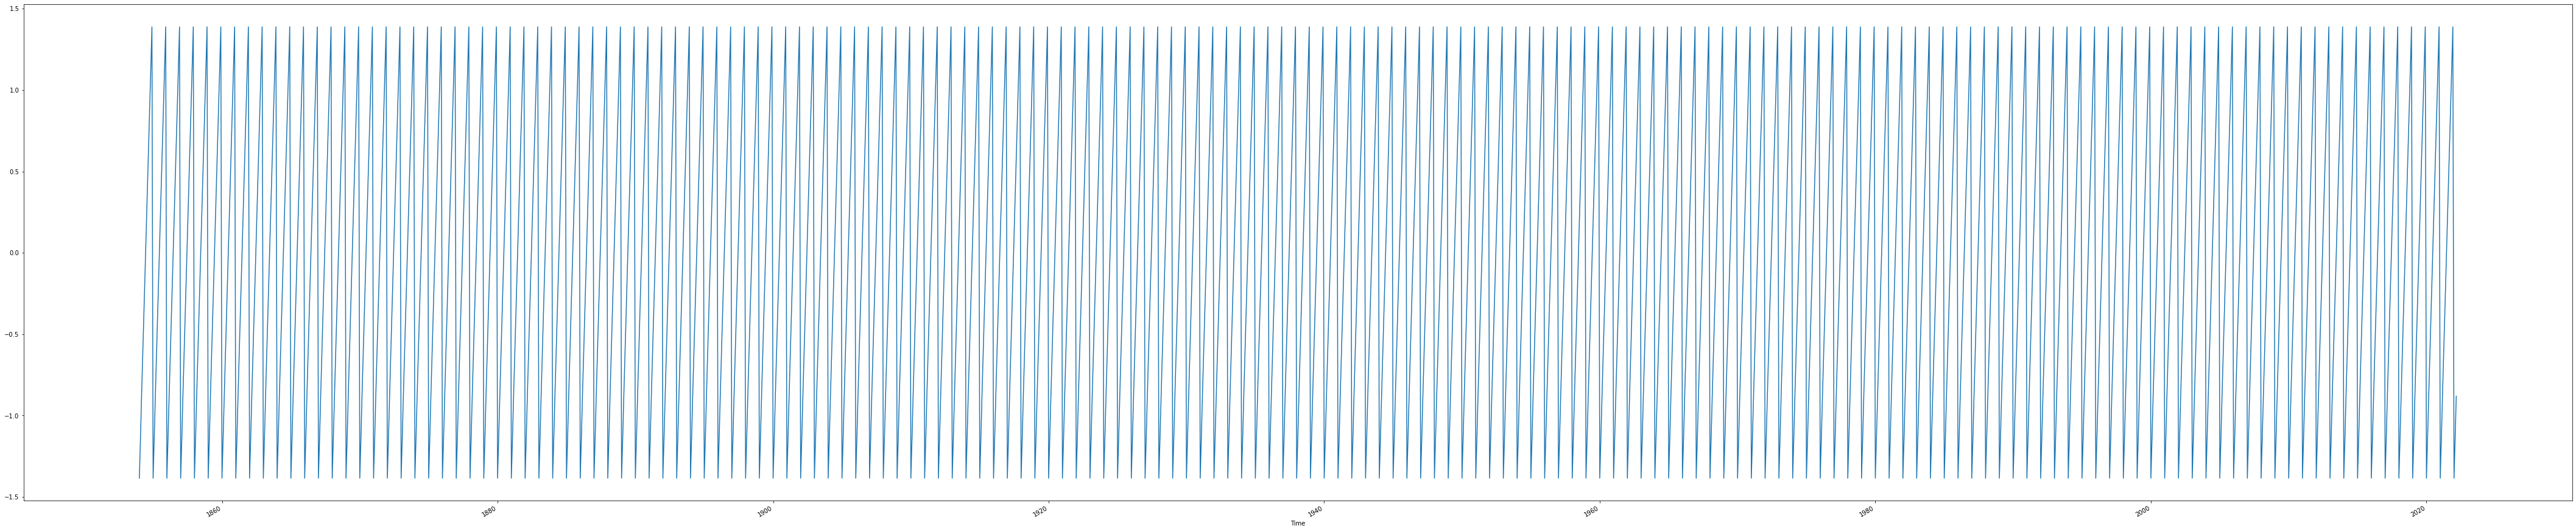

In [33]:
mm = BOX['time.month'] 

mmcor = np.corrcoef(detrend.values, mm)[1,0]      # in [-1,1]
slope = mmcor *np.std(detrend).values /np.std(mm) # K/month units

# seas12 is a time series of the right shape, linear regression slope on mm-mm.mean()
seas12 = detrend.copy()*0 + slope*(mm - mm.mean())
seas12.plot(size=15,aspect=5)

Text(0.5, 1.0, 'Detrended blue, deseasonalized orange')

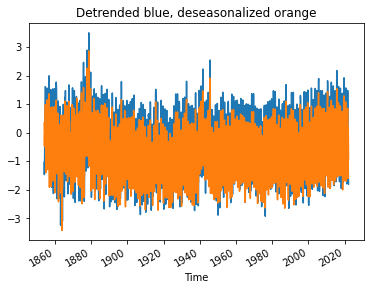

In [34]:
deseas = detrend-seas12
detrend.plot(); deseas.plot(); plt.title('Detrended blue, deseasonalized orange')

# Now low-pass (LP), band-pass(BP), and residual high pass (HP)


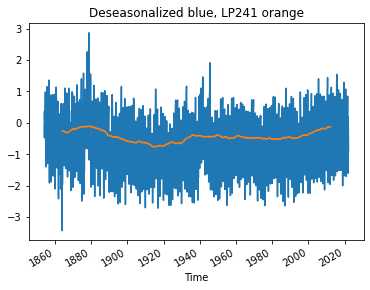

In [35]:
# LP is rolling means over 241 months (20 years)
LP = deseas.rolling(time=241, center=True).mean()# .dropna("time")

deseas.plot(); LP.plot()
plt.title('Deseasonalized blue, LP241 orange')
resid = deseas-LP

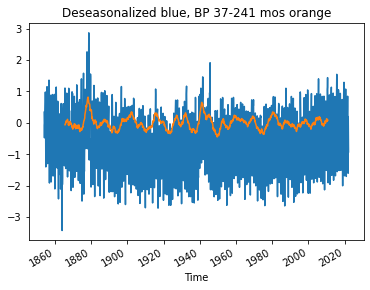

In [36]:
# BP is rolling mean of resid over 49 months (4 years)
BP = resid.rolling(time=37, center=True).mean() #.dropna("time")

deseas.plot(); BP.plot()
plt.title('Deseasonalized blue, BP 37-241 mos orange')
HP = resid-BP

Text(0.5, 1.0, 'HP (49 mos) and VHP (13 mos)')

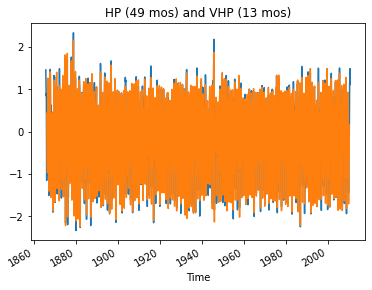

In [37]:
VHP = HP.copy()-HP.rolling(time=13, center=True).mean() #.dropna("time")

HP.plot(); VHP.plot(); plt.title('HP (49 mos) and VHP (13 mos)')

# Shuffle time series: a null hypothesis 
Careful, it is shuffled in place, not returned as a result! Do it on a copy

In [85]:
RND = BOX.copy()
np.random.shuffle(RND)

# Make correlation and regression maps from time series: 
## Full BOX @0N-180E, and trend, seas12, LP, BP, HP, VHP.

Regress on SST itself: units are K/K, guaranteed to be about 1 in the box itself in each panel. 

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
tsnames = ['trend','seas12','LP','BP','VHP','BOX','RND']

In [86]:
for tsname in tsnames: 
    command = tsname+'corr = xr.corr('+tsname+',ds.sst, dim="time");'# +tsname+'cov.plot(); plt.title('+tsname+')'
    print(command)
    exec(command)
    command = tsname+'reg = '+tsname+'corr'+'* ds.sst.std(dim="time") /'+tsname+'.std(dim="time")'
    print(command)
    exec(command)

trendcorr = xr.corr(trend,ds.sst, dim="time");
trendreg = trendcorr* ds.sst.std(dim="time") /trend.std(dim="time")
seas12corr = xr.corr(seas12,ds.sst, dim="time");
seas12reg = seas12corr* ds.sst.std(dim="time") /seas12.std(dim="time")
LPcorr = xr.corr(LP,ds.sst, dim="time");
LPreg = LPcorr* ds.sst.std(dim="time") /LP.std(dim="time")
BPcorr = xr.corr(BP,ds.sst, dim="time");
BPreg = BPcorr* ds.sst.std(dim="time") /BP.std(dim="time")
VHPcorr = xr.corr(VHP,ds.sst, dim="time");
VHPreg = VHPcorr* ds.sst.std(dim="time") /VHP.std(dim="time")
BOXcorr = xr.corr(BOX,ds.sst, dim="time");
BOXreg = BOXcorr* ds.sst.std(dim="time") /BOX.std(dim="time")
RNDcorr = xr.corr(RND,ds.sst, dim="time");
RNDreg = RNDcorr* ds.sst.std(dim="time") /RND.std(dim="time")


trend.plot()
trendcorr.plot(); plt.title('trend correlation coeff.')
seas12.plot()
seas12corr.plot(); plt.title('seas12 correlation coeff.')
LP.plot()
LPcorr.plot(); plt.title('LP correlation coeff.')
BP.plot()
BPcorr.plot(); plt.title('BP correlation coeff.')
VHP.plot()
VHPcorr.plot(); plt.title('VHP correlation coeff.')
BOX.plot()
BOXcorr.plot(); plt.title('BOX correlation coeff.')
RND.plot()
RNDcorr.plot(); plt.title('RND correlation coeff.')


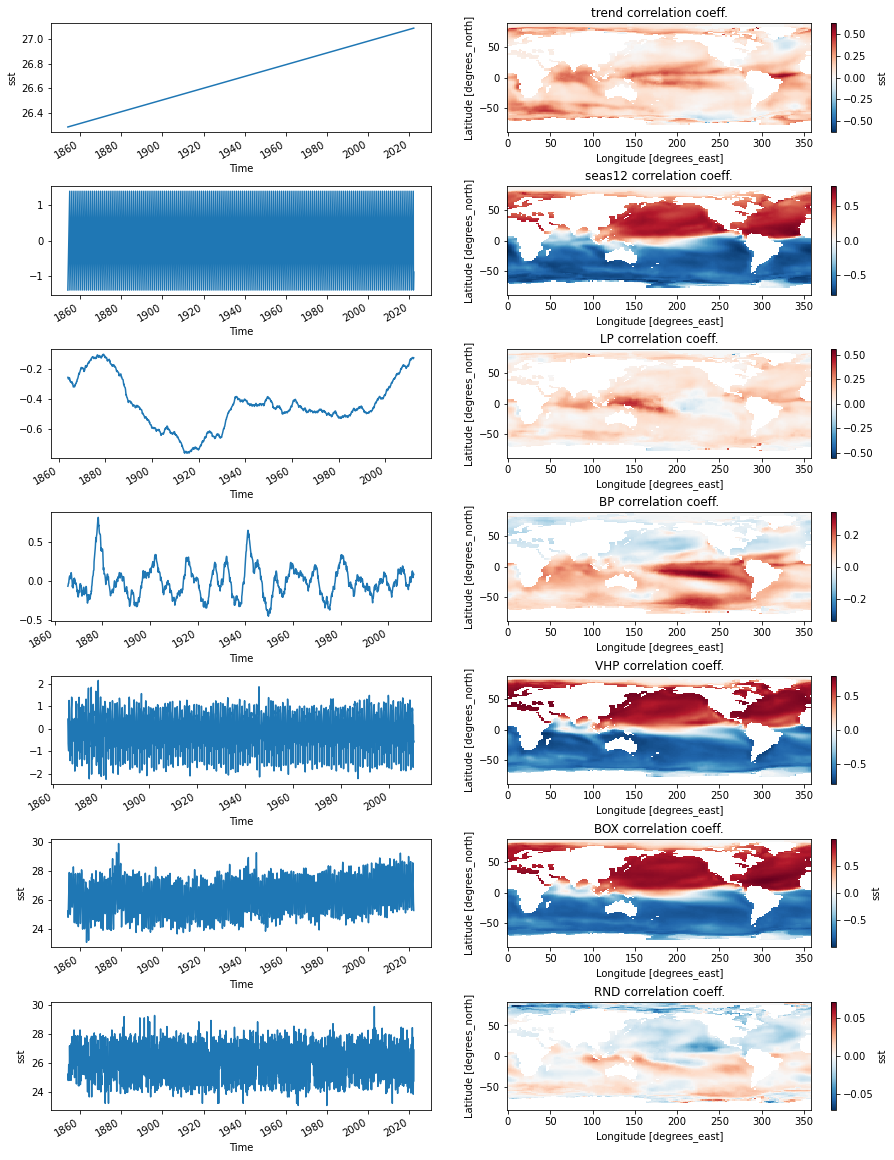

In [87]:
# CORRELATION COEFFICIENTS

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
NPLOTS = len(tsnames)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(NPLOTS, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(NPLOTS, 2, 2*i + 2)
    command = tsname+"corr.plot(); plt.title('"+tsname+" correlation coeff.')"
    print(command)
    exec(command)

trend.plot()
trendreg.plot(); plt.title('trend regression (gridpt units/ts unit)')
seas12.plot()
seas12reg.plot(); plt.title('seas12 regression (gridpt units/ts unit)')
LP.plot()
LPreg.plot(); plt.title('LP regression (gridpt units/ts unit)')
BP.plot()
BPreg.plot(); plt.title('BP regression (gridpt units/ts unit)')
VHP.plot()
VHPreg.plot(); plt.title('VHP regression (gridpt units/ts unit)')
BOX.plot()
BOXreg.plot(); plt.title('BOX regression (gridpt units/ts unit)')
RND.plot()
RNDreg.plot(); plt.title('RND regression (gridpt units/ts unit)')


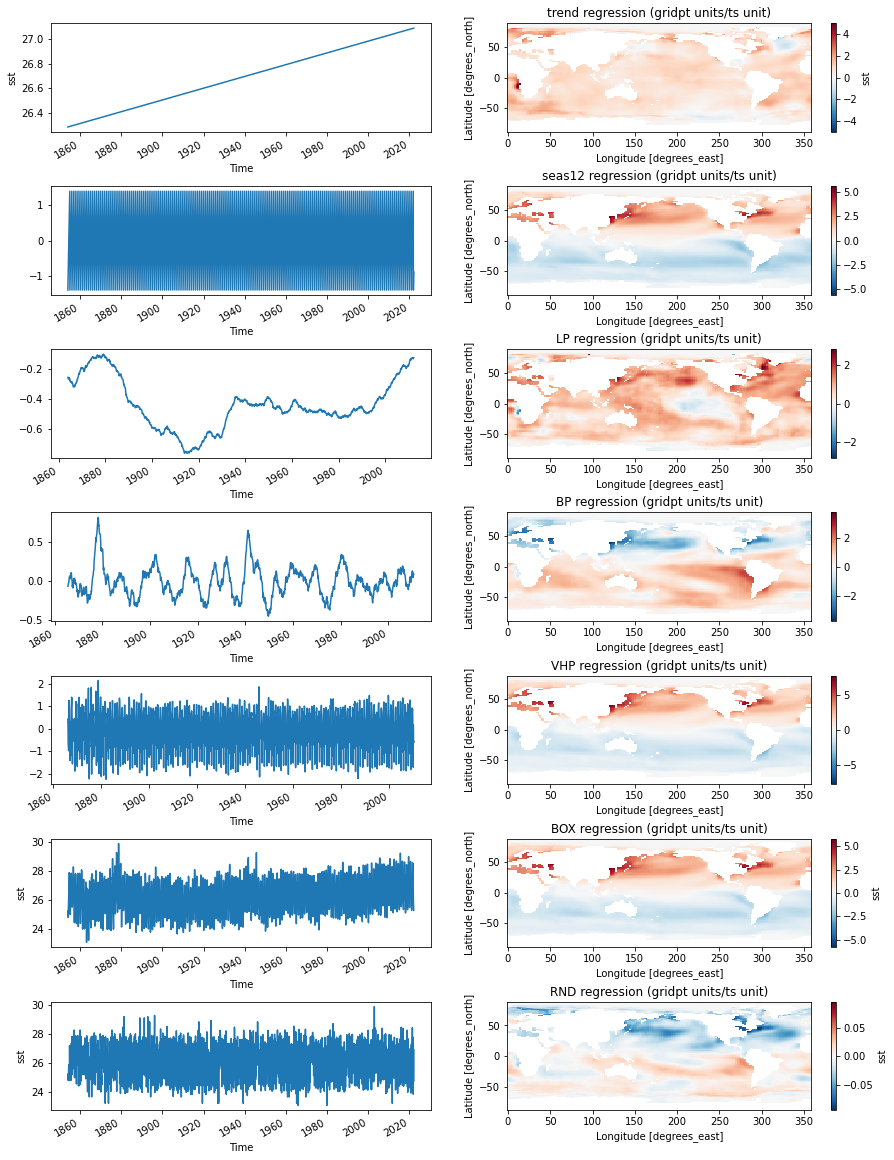

In [88]:
# REGRESSION COEFFICIENT: Guaranteed near 1 in BOX area, except for RND

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
NPLOTS = len(tsnames)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(NPLOTS, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(NPLOTS, 2, 2*i + 2)
    command = tsname+"reg.plot(); plt.title('"+tsname+" regression (gridpt units/ts unit)')"
    print(command)
    exec(command)

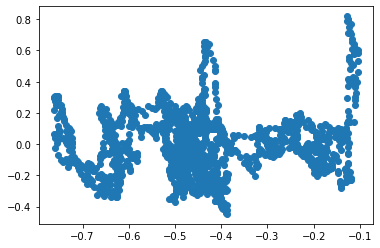

In [124]:
plt.scatter(LP,BP) # uncorrelated: orthogonal predictors, separable results

# Regress ICOADS cloudiness on SST

Since 'time' is a labeled dimension in both datasets, xarray will do it sensibly for the period of overlap. I don't know why this dataset has values everywhere: satellite era has global maps in there? Units are oktas. 

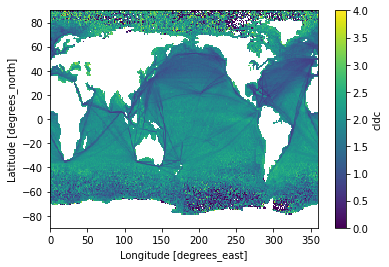

In [142]:
URL = 'https://psl.noaa.gov//thredds/dodsC/Datasets/icoads/1degree/global/enh/cldc.mean.nc'
ds2 = xr.open_dataset(URL)
ds2.cldc.std(dim='time').plot()

In [143]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 745)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2022-01-01
Data variables:
    cldc     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                           ICOADS 1-degree Enhanced
    history:                         Release 3.0.2
    Conventions:                     CF-1.2
    references:                      http://www.esrl.noaa.gov/psd/data/gridde...
    dataset_title:                   International Comprehensive Ocean-Atmosp...
    website:                         icoads.noaa.gov
    doi:                             doi:                                    ...
    source:                          National Centers for Environmental Infor...
    version:                         Release 3.0.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [140]:
for tsname in tsnames: 
    command = tsname+'corrC = xr.corr('+tsname+',ds2.cldc, dim="time");'# +tsname+'cov.plot(); plt.title('+tsname+')'
    print(command)
    exec(command)
    command = tsname+'regC = '+tsname+'corr'+'* ds2.cldc.std(dim="time") /'+tsname+'.std(dim="time")'
    print(command)
    exec(command)

trendcorrC = xr.corr(trend,ds2.cldc, dim="time");
trendregC = trendcorr* ds2.cldc.std(dim="time") /trend.std(dim="time")
seas12corrC = xr.corr(seas12,ds2.cldc, dim="time");
seas12regC = seas12corr* ds2.cldc.std(dim="time") /seas12.std(dim="time")
LPcorrC = xr.corr(LP,ds2.cldc, dim="time");
LPregC = LPcorr* ds2.cldc.std(dim="time") /LP.std(dim="time")
BPcorrC = xr.corr(BP,ds2.cldc, dim="time");
BPregC = BPcorr* ds2.cldc.std(dim="time") /BP.std(dim="time")
VHPcorrC = xr.corr(VHP,ds2.cldc, dim="time");
VHPregC = VHPcorr* ds2.cldc.std(dim="time") /VHP.std(dim="time")
BOXcorrC = xr.corr(BOX,ds2.cldc, dim="time");
BOXregC = BOXcorr* ds2.cldc.std(dim="time") /BOX.std(dim="time")


trend.plot()
trendregC.plot(); plt.title('trend regression (oktas/ K in box)')
seas12.plot()
seas12regC.plot(); plt.title('seas12 regression (oktas/ K in box)')
LP.plot()
LPregC.plot(); plt.title('LP regression (oktas/ K in box)')
BP.plot()
BPregC.plot(); plt.title('BP regression (oktas/ K in box)')
VHP.plot()
VHPregC.plot(); plt.title('VHP regression (oktas/ K in box)')
BOX.plot()
BOXregC.plot(); plt.title('BOX regression (oktas/ K in box)')


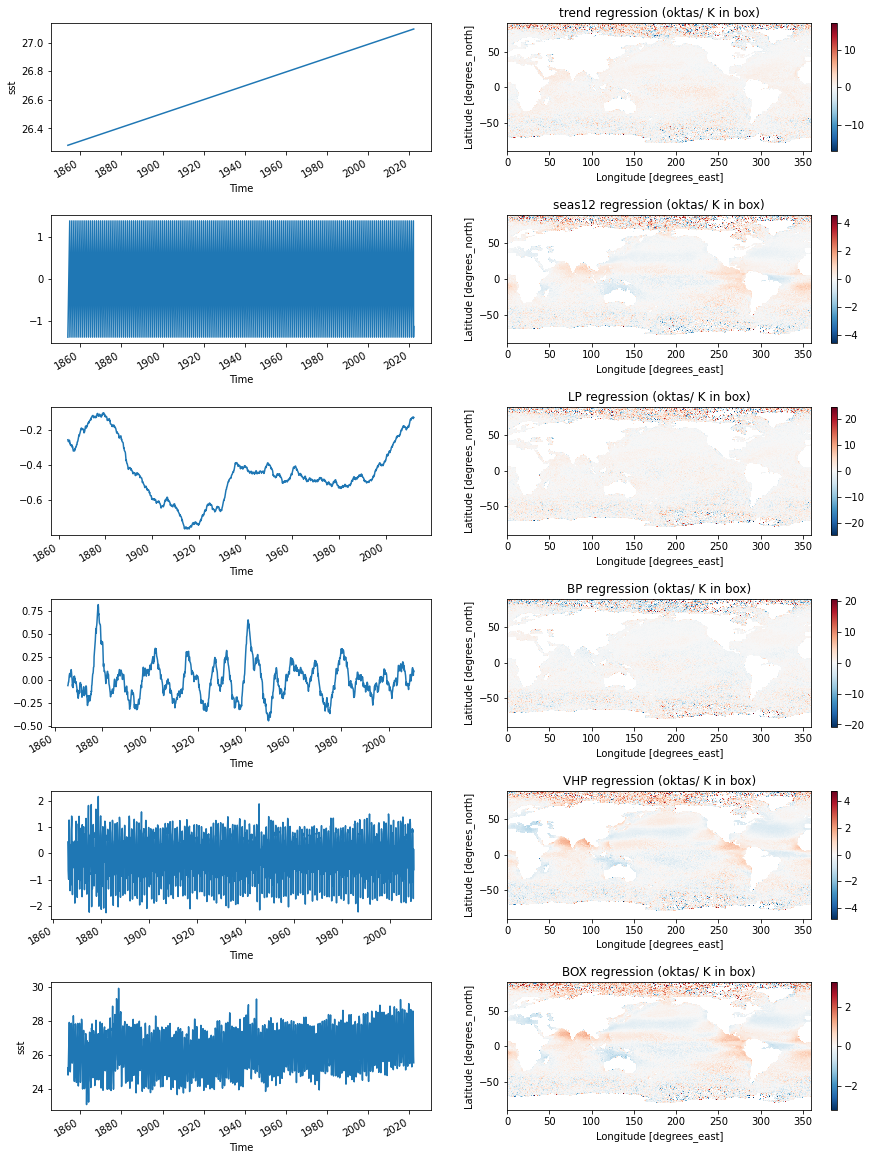

In [144]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(6, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(6, 2, 2*i + 2)
    command = tsname+"regC.plot(); plt.title('"+tsname+" regression (oktas/ K in box)')"
    print(command)
    exec(command)

# EOF decomposition of total SST(lon,lat,months)

In [126]:
# EOFs of total SST field
from eofs.xarray import Eof

NEOF = 5

solver = Eof( ds.sst )
pc = solver.pcs(npcs=NEOF)
eof = solver.eofs(neofs=NEOF)

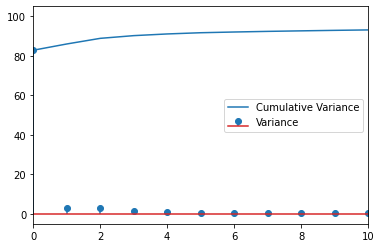

In [127]:
variance=solver.varianceFraction() # this is same as eigenvals/sum(eigenvals)

plt.stem(variance*100.0,label="Variance")
plt.plot(variance.cumsum()*100.0,label="Cumulative Variance")
plt.xlim(0,10,1)
plt.legend()

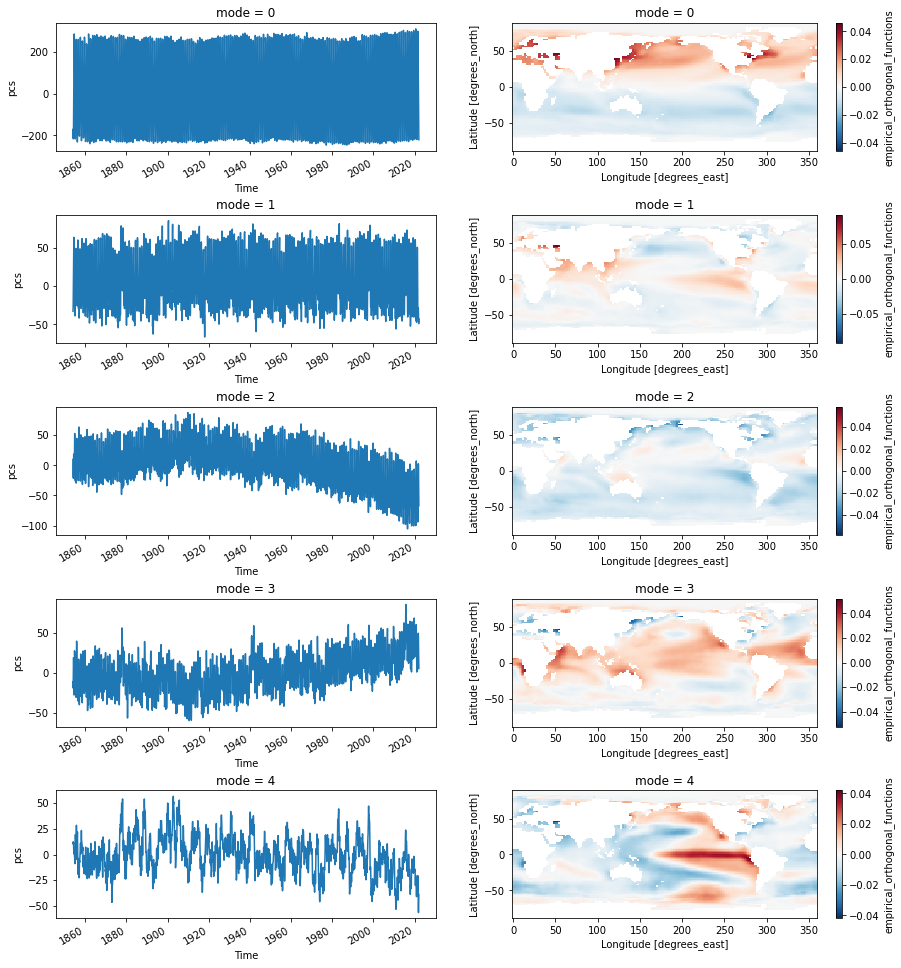

In [128]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

for i in range(NEOF):
    ax = plt.subplot(6, 2, 2*i + 1)
    pc[:,i].plot()
    ax = plt.subplot(6, 2, 2*i + 2)
    eof[i].plot()
    



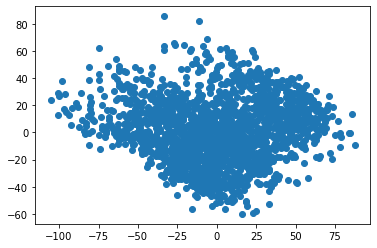

In [132]:
# PC2 and PC3 both seem to contain some trend, yet are orthogonal. Wassup with that? 
# Yes uncorrelated because of their high frequency component! 
plt.scatter(pc[:,2], pc[:,3])

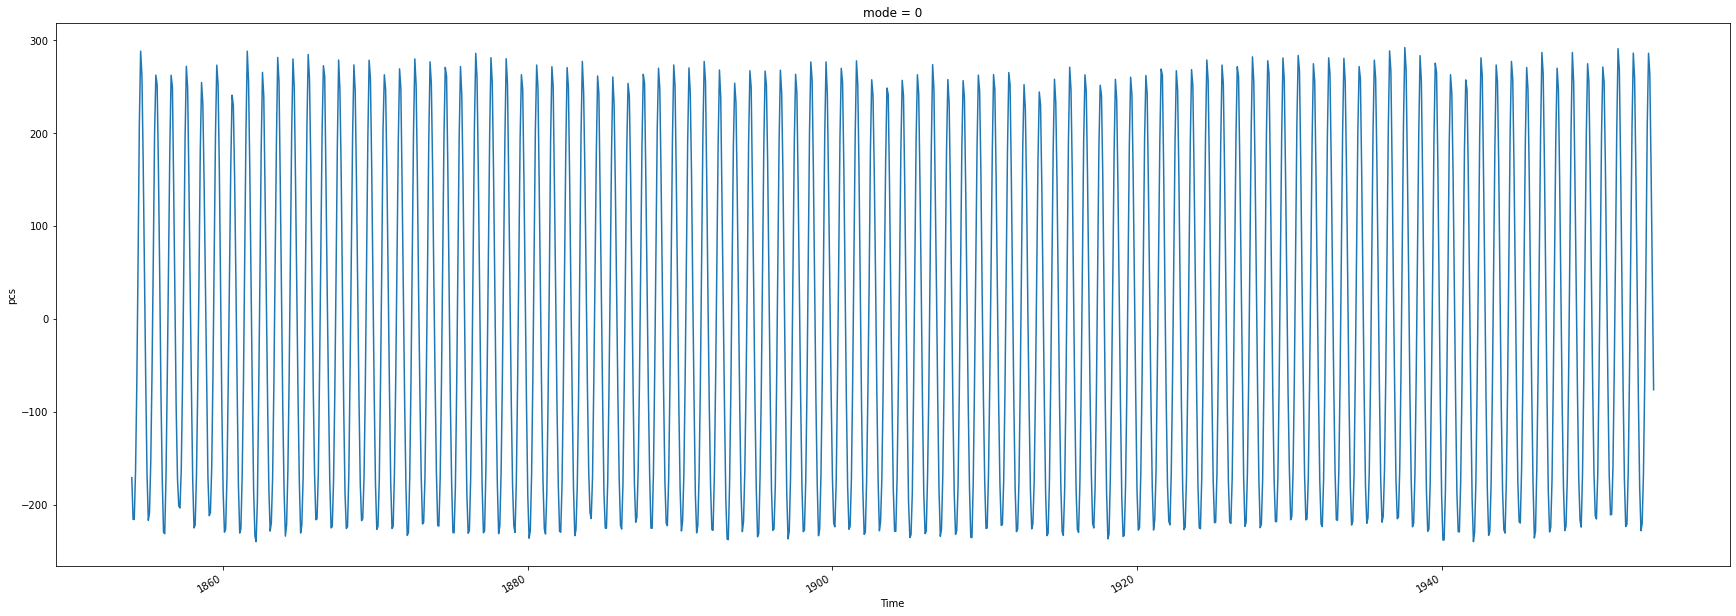

In [133]:
# Mode 0 is seasonal cycle: see time series
pc[0:1200,0].plot(size=10, aspect=3)